# Surface concentrations

In [12]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import netCDF4 as nc
import sys
sys.path.insert(1, '/ocean/brogalla/GEOTRACES/analysis-brogalla/paper1/figures/')
import modules.mapping_functions as mf
import pandas as pd
from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import gsw

%matplotlib inline

#### Parameters:

In [8]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2015
results_folder1 = f'/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-{year}_20220422/'

land_color         = '#a9a7a2'
land_outline_color = '#373736'

#### Load files:

In [3]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon = np.array(mesh.variables['nav_lon'])
ANHA12_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_sub  = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
e3t        = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

In [4]:
ref   = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc',  'r')
lons_model  = np.array(ref.variables['nav_lon'])
lats_model  = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

In [5]:
results  = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc')
dissolmn = np.array(results.variables['dissolmn'][:,0,:,:,:])*1e9 # nM units
oxidismn = np.array(results.variables['oxidismn'][:,0,:,:,:])*1e9 # nM units

In [6]:
# GEOTRACES 2021 Intermediate data product:
folder_data = '/ocean/brogalla/GEOTRACES/data/'
sw          = xr.open_dataset(f'{folder_data}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_kYw7mpQ2.nc')
GTR_cruises = sw['metavar1']
GTR_lons    = sw['longitude'].values # degrees east
GTR_lats    = sw['latitude'].values  # degrees north
GTR_pres    = sw['var1'].values      # Pressure from CTD sensor [dbar]
GTR_depth   = sw['var2'].values      # Depth below sea surface calculated from pressure [m]
GTR_temp    = sw['var3'].values      # Temperature from CTD sensor in the ITS-90 convention. [C]
GTR_sal     = sw['var4'].values      # Practical salinity from CTD sensor on the PSS-1978 scale
GTR_dMn     = sw['var12'].values     # Concentration of dissolved Mn in nmol/kg, method may include Mn(II) plus Mn(III)

GTR_pressure   = np.ma.masked_where(GTR_pres < -1e8, GTR_pres)
# practical salinity --> absolute salinity (g/kg)
GTR_lons_tile  = np.tile(GTR_lons, (345,1)).transpose()
GTR_lats_tile  = np.tile(GTR_lats, (345,1)).transpose()
GTR_sal_abs    = gsw.conversions.SA_from_SP(GTR_sal, GTR_pressure, GTR_lons_tile, GTR_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
GTR_density    = gsw.density.rho_t_exact(GTR_sal_abs, GTR_temp, GTR_pressure) # kg/m3

# convert dMn from nmol/kg --> nmol/L (nmol/kg * kg/m3 * 1 m3 / 1000 L)
GTR_dMn_nM = GTR_dMn*GTR_density*1e-3

GTR_dMn_PML = np.ma.masked_where((GTR_depth > 35), GTR_dMn_nM)
GTR_dMn_PML = np.ma.masked_where(np.isnan(GTR_dMn_nM), GTR_dMn_PML)
GTR_dMn_PML_mean = GTR_dMn_PML.mean(axis=1)

In [7]:
# Concentration of dMn in the Beaufort Sea in 2009.
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = np.array(IPY['Station name'].astype('string'))
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn_nmolkg = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values

# Convert nmol / kg to nmol / L
IPY_density             = IPY['Density'].astype('float').values # kg / L
IPY_depths_cruise_sheet = IPY['Depth [m] cruise sheet'].astype('float').values
IPY_dMn_nmolL = IPY_dMn_nmolkg * IPY_density * 1e-3

IPY_dMn_PML = np.ma.masked_where(IPY_depths > 35, IPY_dMn_nmolL)
IPY_stns = list(dict.fromkeys(IPY_names_full))

IPY_dMn_PML_mean = np.zeros(len(IPY_stns))
for i, stn in enumerate(IPY_stns):
    IPY_dMn_PML_mean[i] = np.ma.mean(IPY_dMn_PML[IPY_names_full==stn])
    
IPY_lons_mean = list(dict.fromkeys(IPY_lons_full))
IPY_lats_mean = list(dict.fromkeys(IPY_lats_full))

#### Functions:

In [45]:
def plot_layer(plot_variable, vmin=0,vmax=35, savefig=False, obs=True):
    
    fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

    proj1 = Basemap(projection='stere',lat_0 = 77.1, lon_0 = -85, resolution='i', width=4.5e6, height=2.98e6, ax=ax1)
#     proj1.drawparallels(np.arange(int(59),int(90),2),labels=[1,0,0,0], linewidth=0.0, fontsize=5)
#     proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0, fontsize=5)
    proj1.drawcoastlines(color=land_outline_color, linewidth=1.0)
    proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);

    x, y = proj1(lons_model, lats_model)

    pcolor  = proj1.pcolormesh(x, y, plot_variable, cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax)
    contour = proj1.contourf(np.zeros_like(x), np.zeros_like(y), np.zeros_like(plot_variable), np.arange(vmin,vmax+1,1),\
                             cmap=cmocean.cm.dense, vmin=vmin, vmax=vmax, extend='both')

    
    # Plot observations over top:
    # mask outside of domain
    if obs:
        GTR_lons_ma = np.ma.masked_where((GTR_lats > 85) | (GTR_lons > 290) | ((GTR_lons < 200) & ((GTR_lats > 78))) \
                                         | ((GTR_lons < 203) & (GTR_lats < 74)), GTR_lons)
        GTR_lats_ma = np.ma.masked_where((GTR_lats > 85) | (GTR_lons > 290) | ((GTR_lons < 200) & ((GTR_lats > 78))) \
                                         | ((GTR_lons < 203) & (GTR_lats < 74)), GTR_lats)
        x_GTR, y_GTR = proj1(GTR_lons_ma, GTR_lats_ma)

        # all GEOTRACES: # exclude one point from GIPY11
        proj1.scatter(x_GTR[GTR_cruises != b'GIPY11'], y_GTR[GTR_cruises != b'GIPY11'], c=GTR_dMn_PML_mean[GTR_cruises != b'GIPY11'], \
                      s=50, zorder=3, edgecolor='w', marker='.', \
                      linewidth=0.5, vmin=0, vmax=vmax, cmap=cmocean.cm.dense, label='2015 GEOTRACES GN02, GN03')
        
        # US GEOTRACES:
        proj1.scatter(x_GTR[GTR_cruises == b'GN01'], y_GTR[GTR_cruises == b'GN01'], c=GTR_dMn_PML_mean[GTR_cruises == b'GN01'], \
                      s=50, zorder=3, edgecolor='w', marker='.', \
                      linewidth=0.5, vmin=0, vmax=vmax, cmap=cmocean.cm.dense, label='2015 GEOTRACES GN01')
    
        # IPY: 
        x_IPY, y_IPY = proj1(IPY_lons_mean, IPY_lats_mean)    
        proj1.scatter(x_IPY, y_IPY, c=IPY_dMn_PML_mean, s=50, zorder=3, edgecolor='w', marker='.', \
                      linewidth=0.5, vmin=0, vmax=vmax, cmap=cmocean.cm.dense, label='2009 GIPY14')
    
    cbar_ax = fig.add_axes([0.15, 0.21, 0.025, 0.25])
    cbar    = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Dissolved Mn [nM]', fontsize=6) 
    cbar_ax.tick_params(axis='both', which='major', labelsize=6)
    
    ax2   = fig.add_axes([0.68, 0.54, 0.35, 0.35])
    proj2 = Basemap(projection='ortho',lon_0=-40,lat_0=40, resolution='h', ax=ax2)
    proj2.drawmapboundary(fill_color='white')
    proj2.drawlsmask(land_color = land_color, ocean_color="#131d44", resolution = 'h',zorder=2)  
    proj2.fillcontinents(color=land_color, lake_color=land_color, zorder=3);
    
    x2, y2 = proj2(ANHA12_lon, ANHA12_lat)
     # Sub-domain
    proj2.plot(x2[imin:imax,jmin], y2[imin:imax,jmin], 'w-', lw=0.9, zorder=3)
    proj2.plot(x2[imin:imax,jmax], y2[imin:imax,jmax], 'w-', lw=0.9, zorder=3)
    proj2.plot(x2[imin,jmin:jmax], y2[imin,jmin:jmax], 'w-', lw=0.9, zorder=3)
    proj2.plot(x2[imax,jmin:jmax], y2[imax,jmin:jmax], 'w-', lw=0.9, zorder=3)
    # full domain
    grid_reso=10
    proj2.plot(x2[460:-1:grid_reso,0]   , y2[460:-1:grid_reso,0]        , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
    proj2.plot(x2[0,370:-1:grid_reso]   , y2[0,370:-1:grid_reso]        , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
    proj2.plot(x2[100:-1:grid_reso,-1]  , y2[100:-1:grid_reso,-1]       , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
    proj2.plot(x2[-1,0:-1:grid_reso]    , y2[-1,0:-1:grid_reso]         , 'w--', lw=0.8, zorder=3, dashes=(2, 2))
    xline_add = [x2[500,0], x2[700,70], x2[1100,0], x2[0,370]]
    yline_add = [y2[240,-1], y2[85,-80], y2[80,0], y2[0,370]]
    proj2.plot(xline_add, yline_add, 'w--', lw=0.8, zorder=3, dashes=(2, 2))
      
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R5-surface-fields-January.jpg', \
                       bbox_inches='tight', dpi=300)
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R5-surface-fields-January.svg', \
                       bbox_inches='tight', dpi=300, format='svg')
    
    return

In [46]:
def calculate_depth_weighted(dMn, levels=(0,16)):
    
    dMn_weighted     = dMn[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_top        = np.zeros_like(mesh_bathy[imin:imax,jmin:jmax])
    if levels[0] != 0:
        depth_top[mesh_bathy[imin:imax,jmin:jmax] > depth_model[levels[0]-1]] = depth_model[levels[0]-1] # top of layer is not the surface
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depth_model[levels[1]-1]] = depth_model[levels[1]-1]
    delta_depth      =  depth_bottom - depth_top
                 
    # calculate average:
    dMn_weighted_ave = np.sum(dMn_weighted, axis=0) / delta_depth
    
    return dMn_weighted_ave

#### Figures of surface concentrations:

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


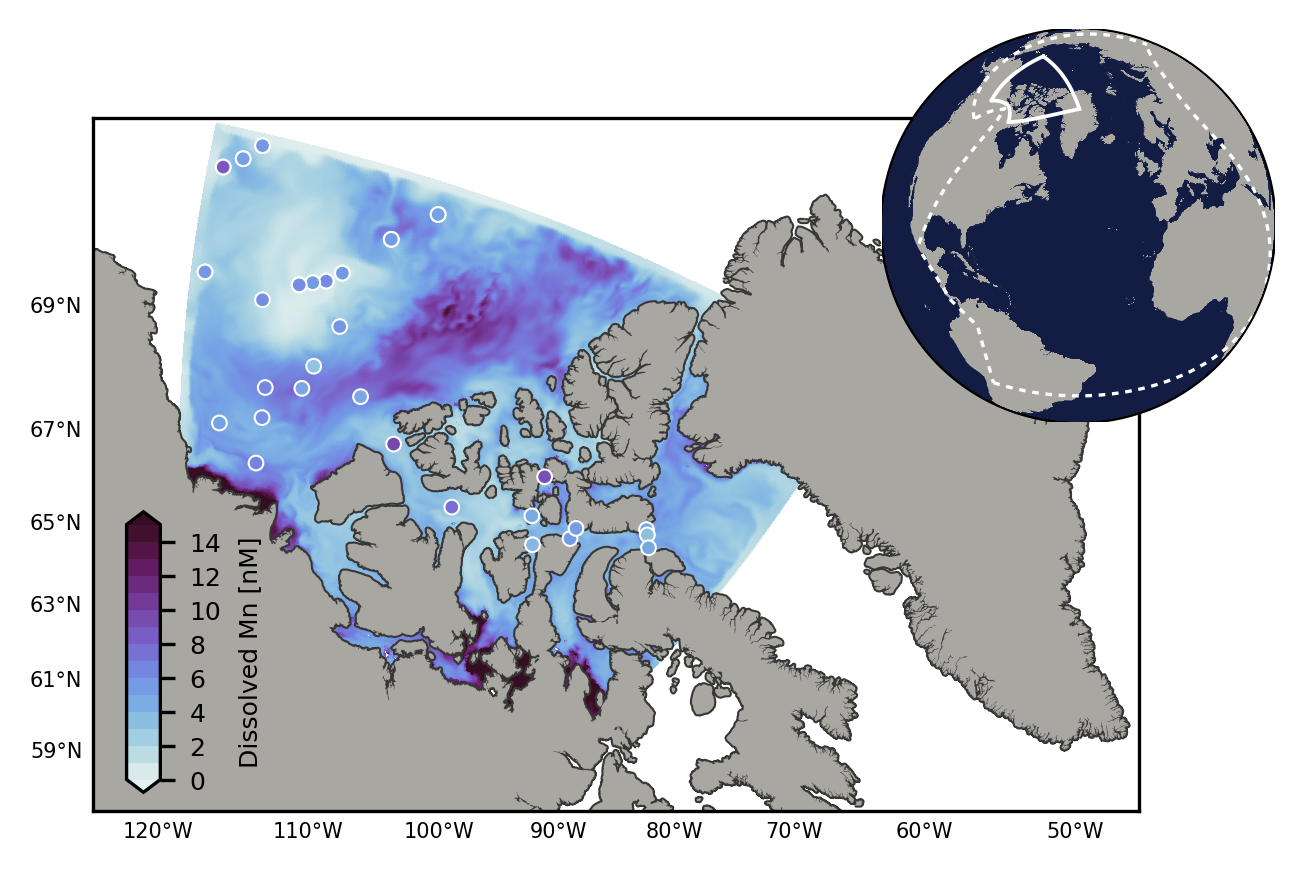

In [47]:
month=7
plot_variable = calculate_depth_weighted(dissolmn[month,:,:,:], levels=(3,16))
plot_layer(plot_variable,vmin=0,vmax=15, savefig=False)